In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch as torch
import pywt
from scipy.signal import welch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from xgboost import XGBClassifier

In [6]:
import numpy as np
import pywt
from scipy.signal import welch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGUtil:
    @staticmethod
    def load_data(file_path, column_names=['spike hz']):
        """Load multi-channel EEG data from a CSV file and normalize it.

        Parameters:
        - file_path: Path to the CSV file.
        - column_names: List of EEG signal column names to load.

        Returns:
        - signal: 2D numpy array (channels × time), normalized.
        """
        data = pd.read_csv(file_path)

        # 确保所有列都存在
        available_columns = [col for col in column_names if col in data.columns]
        if not available_columns:
            raise ValueError(f"None of the specified columns {column_names} exist in {file_path}")

        signal = data[available_columns].values.T  # (channels, time)

        # **🔥 强制 z-score 归一化**
        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True)

        # 防止标准差为 0，避免 NaN
        std[std == 0] = 1e-8  
        
        #signal = (signal - mean) / std  # 归一化
        
        return signal

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=0):
        """Pad or truncate multi-channel signal to the target length."""
        signal = np.array(signal)  # Ensure it's a NumPy array
        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate

        padding_size = target_length - current_length
        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        return np.hstack((signal, pad_values))  # Concatenate along time axis

In [7]:
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, ssd_file=None,start_time=16,target_length=600, strategy='padding', 
                 padding_mode="constant", use_labels=False, augment=False,num_good=1,num_bad=1,column_names=['spike hz']):
        
        """
        EEG signal datasets with support for data enhancement (random fill). 

        Parameters: 
        - data_folder: path of the EEG data folder 
        - outcome_file: CSV file with patient ID and outcome (optional) 
        - target_length: indicates the padding length of the target 
        - strategy: wavelet ('padding', 'wavelet', 'psd') 
        - padding_mode: indicates the fill mode ('constant', 'reflect',...). 
        - use_labels: indicates whether to use labels 
        - augment: Whether data enhancement is enabled (randomly fill different lengths) 
        """

        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment # 是否启用数据增强
        self.column_names = column_names #Feature Chosen
        
        self.num_good = num_good
        self.num_bad = num_bad
        
        self.start_time=start_time
        self.end_time=int((target_length/12)+self.start_time)

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
       
        # Read 'rosc sec' start time
        ssd_df = pd.read_csv(ssd_file)
        # Get `pat_ID`
        ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")
        #  Take the smallest 'rosc sec' of each 'pat ID' 
        self.rosc_dict = ssd_df.groupby("pat_ID")["rosc_sec"].min().to_dict()
        
        # LOAD Labels
        self.outcome_dict = {}
        if use_labels and outcome_file:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]
        
        self.valid_files = []
        # Filter EEG data conforming to 16h-68h rules
        for f in self.file_list:
            pat_id = f.split('.')[0]

            if pat_id in self.rosc_dict:
                file_path = os.path.join(self.data_folder, f)
                signal = EEGUtil.load_data(file_path, column_names=self.column_names)  #Load Multiple Channel
                rosc_sec = float(self.rosc_dict[pat_id])  # Ensure `rosc_sec` is a float

                # **EEG recording time range**
                start_time = rosc_sec
                end_time = start_time + signal.shape[1] * 300  # Each point represents 5 minutes (=300 seconds)
                # **Skip if the data is completely outside the 16h-68h observation window**
                if end_time < self.start_time * 3600 or start_time > self.end_time * 3600:
                    #print(f"❌ Skipping {pat_id}: EEG data is out of 16h-68h range ({start_time/3600:.1f}h - {end_time/3600:.1f}h)")
                    continue  

                # **Align to the 16h-68h window**
                aligned_signal = self.align_signal(signal, rosc_sec)
                self.valid_files.append((f, aligned_signal))

        print(f"✅ Loaded {len(self.valid_files)} valid EEG files (filtered from {len(self.file_list)} total)")

        # **Count Good/Bad Outcome samples**
        self.good_outcome_count = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
        self.bad_outcome_count = len(self.valid_files) - self.good_outcome_count

        print(f"Good Outcome: {self.good_outcome_count}, Bad Outcome: {self.bad_outcome_count}")

        # **Data Augmentation: Expanding indices**
        self.expanded_indices = []
        for idx, (filename, signal) in enumerate(self.valid_files):
            patient_id = filename.split('.')[0]
            label = self.get_label(patient_id) if self.use_labels else -1

            if self.augment:
                if self.use_labels:
                    # Good Outcome ×10, Bad Outcome ×2
                    if label == 1:
                        repeat_times = self.num_good
                    else:
                        repeat_times = self.num_bad
                else:
                    repeat_times = 1  # Data augmentation for unlabeled data
            else:
                repeat_times = 1  

            for _ in range(repeat_times):
                self.expanded_indices.append((idx, label))  # ✅ Store index & label
    
    def __len__(self):
        # print(f"📏 Dataset __len__: {len(self.expanded_indices)}")  # Ensure `expanded_indices` length is correct
        return len(self.expanded_indices)  # ✅ Must return the number of samples after data augmentation
    
    def __getitem__(self, idx):
        original_idx, label = self.expanded_indices[idx]
        filename, signal = self.valid_files[original_idx]  # Directly retrieve the **aligned** signal
        patient_id = filename.split('.')[0]

        # Get label
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)

        # Perform data augmentation (varies each time)
        if self.augment:
            augmented_signal = self.augment_signal(signal)  # ✅ Apply augmentation directly to the **aligned signal**
        else:
            augmented_signal = signal  # ✅ Use the aligned signal directly

        return torch.tensor(augmented_signal, dtype=torch.float32), label
    
    def align_signal(self, signal, rosc_sec):
        """ Align EEG data to the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        total_signal_length = signal.shape[1]  # Total length of the EEG recording
        
        rosc_sec = float(rosc_sec)  # ✅ Ensure `rosc_sec` is a float
        # print(f"🔍 Processing patient data: rosc_sec={rosc_sec}, total_signal_length={total_signal_length}")

        # **Calculate the starting position of '16h' in the EEG recording**
        start_sec = (self.start_time * 3600) - rosc_sec  
        if start_sec < 0:
            pad_size = abs(start_sec) / 300  # Calculate the number of windows to pad
            start_index = 0  # Start extracting data from the beginning of the EEG recording
        else:
            pad_size = 0  # No padding needed
            start_index = int(start_sec // 300)  # ✅ Convert to integer

        # **Calculate the endpoint index for '68h'**
        end_index = int(min(start_index + target_length, total_signal_length))  # ✅ Convert to integer

        # **Extract EEG data for the 16h-68h observation period**
        aligned_signal = signal[:, start_index:end_index]

        # **Pre-padding (if `rosc_sec > 16h`)**
        if pad_size > 0:
            aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="pre")

        # **Post-padding (if data is less than 52 hours)**
        aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="post")

        # print(f"✅ Aligned signal length: {len(aligned_signal)}")
        return aligned_signal
    
    def pad_signal(signal, target_length, mode="constant", constant_value=0, padding_position="post"):
        """ Pad EEG signal to ensure it reaches `target_length`.

        Parameters:
        - signal: Original EEG signal (numpy array)
        - target_length: Target length (52h = 624 `5min` windows)
        - mode: Padding mode:
            - `constant`: Fill with a fixed value (`constant_value`)
            - `reflect`: Mirror padding
            - `cyclic`: Cyclic padding
            - `edge`: Edge padding
            - `random`: Fill with random values between [min, max]
        - padding_position: `"pre"` (pad at the beginning) or `"post"` (pad at the end)

        Returns:
        - Padded EEG signal (numpy array)
        """

        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate if already long enough

        padding_size = target_length - current_length  # Number of elements to pad

        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)  # Make sure padding shape matches
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        # Ensure proper concatenation along the time axis
        if padding_position == "pre":
            padded_signal = np.hstack((pad_values, signal))  # Pad at the beginning
        else:
            padded_signal = np.hstack((signal, pad_values))  # Pad at the end

        return padded_signal[:, :target_length]  # Ensure exact target length
    
    def augment_signal(self, signal):
        """ Data augmentation: Shift EEG data within the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        channels, current_length = signal.shape  # Current EEG recording length

        # **Check if already aligned to 16h-68h before augmentation**
        if current_length != target_length:
            raise ValueError(f"Before augmentation, signal length should be {target_length}, but received {current_length}")

        # **Augmentation Strategy 1: Random time shift within ±60min**
        max_shift = 12  # `5min` windows, 60 minutes = 12 data points
        shift = np.random.randint(-max_shift, max_shift + 1)  # Random shift in [-12, 12]

        # **Compute new starting index and ensure it remains within bounds**
        start_index = max(0, min(current_length - target_length, shift))
        end_index = min(start_index + target_length, current_length)

        # **Extract EEG data after shifting**
        augmented_signal = signal[:, start_index:end_index]

        # **Augmentation Strategy 2: Apply padding based on `shift` direction**
        if augmented_signal.shape[1] < target_length:
            padding_size = target_length - augmented_signal.shape[1]

            if shift > 0:
                # **向右平移: 在前面填充**
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((pad_values, augmented_signal))  # **确保形状正确**
            elif shift < 0:
                # **向左平移: 在后面填充**
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((augmented_signal, pad_values))
            else:
                # **不平移，直接填充**
                augmented_signal = self.pad_signal(augmented_signal, target_length, self.padding_mode)

        return augmented_signal

    def get_label(self, patient_id):
        """ Get sample label (1 = Good Outcome, 0 = Bad Outcome) """
        return 1 if self.outcome_dict.get(patient_id, 'Bad Outcome') == 'Good Outcome' else 0

    def compare_data_augmentation(self):
        """ Compare the number of samples before and after data augmentation. """
        original_count = len(self.valid_files)  # Count only files that meet the 16h condition
        augmented_count = len(self.expanded_indices)  # Count the number of augmented samples

        print(f"Data count before augmentation: {original_count}")
        print(f"Data count after augmentation: {augmented_count}")
        print(f"Augmentation ratio: {augmented_count / original_count:.2f}x")

        if self.use_labels:
            # Count Good Outcome and Bad Outcome samples in original data (filtered_files)
            good_outcome_original = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
            bad_outcome_original = original_count - good_outcome_original  # Remaining are Bad Outcome samples

            # Count Good Outcome and Bad Outcome samples after augmentation
            good_outcome_augmented = sum(
                1 for (idx, _) in self.expanded_indices  # ✅ Use only idx, ignore label
                if self.get_label(self.valid_files[idx][0].split('.')[0]) == 1
            )
            bad_outcome_augmented = augmented_count - good_outcome_augmented  # Remaining are Bad Outcome samples

            print(f"Good Outcome before augmentation: {good_outcome_original}, after augmentation: {good_outcome_augmented}")
            print(f"Bad Outcome before augmentation: {bad_outcome_original}, after augmentation: {bad_outcome_augmented}")

        return original_count, augmented_count

In [8]:
# AugmentedEEGDataset (适配多通道)
class AugmentedEEGDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, eeg_dataset_instance, augment=True, num_good=10, num_bad=2):
        self.base_dataset = base_dataset
        self.eeg_dataset_instance = eeg_dataset_instance  # 保存实例
        self.augment = augment
        self.num_good = num_good
        self.num_bad = num_bad
        self.expanded_data = []

        for i in range(len(base_dataset)):
            signal, label = base_dataset[i]
            repeat = num_good if label == 1 else num_bad  # 按类别决定增强比例

            for _ in range(repeat):
                # **🔥 兼容多通道数据**
                signal_np = signal.numpy()
                if signal_np.ndim == 2:
                    augmented_signal = self.eeg_dataset_instance.augment_signal(signal_np)
                else:
                    augmented_signal = self.eeg_dataset_instance.augment_signal(signal_np[np.newaxis, :])  # **单通道兼容**

                self.expanded_data.append((augmented_signal, label))

    def __len__(self):
        return len(self.expanded_data)

    def __getitem__(self, idx):
        signal, label = self.expanded_data[idx]
        return torch.tensor(signal, dtype=torch.float32), label
# 统计类别信息
def count_labels(dataset):
    labels = [dataset[i][1] for i in range(len(dataset))]  # 取出所有样本的 label
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

In [9]:
initial_channels = 128
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoder, self).__init__()

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for _ in range(3):
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.flatten_dim = in_channels * seq_length
        self.fc_mean = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # 拉平
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar


class CNNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for _ in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        layers.pop()
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        """ 提取 `latent feature` """
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)  # ✅ 这里返回 `z` 作为 `latent feature`
        return z

# ✅ 计算模型参数
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [10]:
import torch
import torch.nn.functional as F

def compute_loss(losses, method="sum"):
    """
    Compute total loss based on the specified method.

    Parameters:
    - losses (torch.Tensor): A tensor containing the loss values for each channel.
    - method (str): The loss computation method. Options:
        - "sum": Direct summation of losses (most stable).
        - "mean": Compute the mean of losses (normalization by count).
        - "normalized": Normalize losses by their sum to balance contributions.

    Returns:
    - total_loss (torch.Tensor): The computed total loss.
    """
    if method == "sum":
        total_loss = losses.sum()
    elif method == "mean":
        total_loss = losses.mean()
    elif method == "normalized":
        loss_sum = losses.sum().detach() + 1e-6  # Detach to prevent affecting gradients
        normalized_losses = losses / loss_sum
        total_loss = (losses * normalized_losses).sum()
    else:
        raise ValueError(f"Unsupported loss computation method: {method}")
    
    # Avoid NaN issues
    if torch.isnan(total_loss) or total_loss < 1e-6:
        total_loss = torch.tensor(1e-6, device=losses.device)
    
    return total_loss

def train(models, dataloader, optimizer, criterion, alpha, device, kl_loss_enabled=True):
    """ 多 VAE 并行训练（优化版）"""
    for model in models:
        model.train()
    
    running_loss = 0.0

    for data, _ in dataloader:
        data = data.to(device)
        losses = []

        for i, model in enumerate(models):
            optimizer.zero_grad()
            channel_data = data[:, i, :].unsqueeze(1)
            reconstruction, mean, logvar = model(channel_data)

            # 限制 logvar 范围，避免数值不稳定
            logvar = torch.tanh(logvar) * 5

            recon_loss = criterion(reconstruction, channel_data)
            kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - torch.exp(logvar))
            loss = recon_loss + (alpha * kl_loss if kl_loss_enabled else 0)

            # 避免 NaN
            if torch.isnan(loss):
                print(f"Warning: Loss is NaN at channel {i}")
                loss = torch.tensor(1e-6, device=device)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
            optimizer.step()
            
            losses.append(loss.item())

        running_loss += sum(losses) * data.size(0)

    return running_loss / len(dataloader.dataset)

def test(models, dataloader, criterion, device):
    """ 多 VAE 测试（优化版） """
    for model in models:
        model.eval()
    
    running_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            
            losses = []
            for i, model in enumerate(models):
                channel_data = data[:, i, :].unsqueeze(1)
                reconstruction, _, _ = model(channel_data)

                loss = criterion(reconstruction, channel_data)
                
                if torch.isnan(loss):
                    print(f"Warning: NaN loss detected at channel {i}, setting to 0")
                    loss = torch.tensor(1e-6, device=device)
                
                losses.append(loss)

            losses = torch.stack(losses)
            total_loss = compute_loss(losses)
            
            running_loss += total_loss.item() * data.size(0)

    return running_loss / len(dataloader.dataset)

# ✅ 提取潜在变量（保持不变）
def get_latent_variables(models, dataloader):
    """ 提取多个 VAE 的潜在变量 """
    for model in models:
        model.eval()

    all_latent_vars = []
    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(device)

            latent_features = []
            for i, model in enumerate(models):
                channel_data = data[:, i, :].unsqueeze(1)  # 取出对应的单通道数据
                _, mean, _ = model(channel_data)
                latent_features.append(mean.detach().cpu())

            # 拼接各个 VAE 的潜在变量
            all_latent_vars.append(torch.cat(latent_features, dim=1))  # 形状是 (batch_size, 30)

    return torch.cat(all_latent_vars, dim=0)  # 返回合并的潜在变量 (total_samples, 30)

In [11]:
import numpy as np
import torch

def extract_latent_features(vae_models, dataset):
    """
    提取多个 VAE 的 latent features，并进行归一化
    
    参数:
    - vae_models: 训练好的多个 VAE（每个 VAE 处理一个通道）
    - dataset: EEG 数据集

    返回:
    - normalized_latent_features: (batch_size, num_channels * latent_dim) 归一化后的特征
    - labels: 样本对应的标签
    """
    latent_features = []
    labels = []

    num_eeg_channels = len(vae_models)  # 🚀 确保与 VAE 数量匹配
    
    # 进入评估模式
    for model in vae_models:
        model.eval()

    with torch.no_grad():
        for i in range(len(dataset)):
            signal, label = dataset[i]

            if isinstance(signal, torch.Tensor):
                signal = signal.to(device)  # 🚀 (num_channels, seq_length)
            else:
                signal = torch.tensor(signal, dtype=torch.float32).to(device)

            channel_latent_vectors = []
            for ch in range(num_eeg_channels):
                channel_data = signal[ch, :].unsqueeze(0).unsqueeze(0).to(device)  # 🚀 取单通道并增加 batch 维度
                latent_vector = vae_models[ch].get_embedding(channel_data).cpu().numpy()
                channel_latent_vectors.append(latent_vector.flatten())

            latent_features.append(np.concatenate(channel_latent_vectors))  # 🚀 拼接 3 个通道的 latent vector
            labels.append(label)

    latent_features = np.array(latent_features)  # 🚀 (num_samples, num_channels * latent_dim)

    # 🚀 **对 `latent feature` 进行 normalize**
    mean = np.mean(latent_features, axis=0, keepdims=True)  # 🚀 计算均值
    std = np.std(latent_features, axis=0, keepdims=True)  # 🚀 计算标准差
    std[std == 0] = 1e-8  # 防止除以 0
    normalized_latent_features = (latent_features - mean) / std  # 🚀 z-score 归一化

    print(f"✅ Feature extraction complete! Extracted {len(normalized_latent_features)} samples.")
    return normalized_latent_features, np.array(labels)



# ✅ 2️⃣ 可视化 **多通道 EEG**
def visualize_augmented_samples(dataset, num_samples=5):
    """
    随机选择 num_samples 个 EEG 样本并可视化 **多通道** 波形
    
    参数:
    - dataset: EEGDataset 实例
    - num_samples: 需要可视化的样本数
    """
    num_channels = dataset.valid_files[0][1].shape[0]  # 🚀 获取通道数
    fig, axes = plt.subplots(num_samples, num_channels, figsize=(10, 2 * num_samples))

    if num_channels == 1:
        axes = np.expand_dims(axes, axis=1)  # 统一 shape 处理

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)  # 随机选择样本
        sample, label = dataset[idx]  # 获取样本
        sample = sample.numpy()  # 🚀 变回 NumPy 数组，shape: (num_channels, 时间步)

        start_time = dataset.start_time  # 开始时间 (小时)
        time_axis = np.linspace(start_time, start_time + (sample.shape[1] - 1) * 5 / 60, sample.shape[1])

        for ch in range(num_channels):  # 🚀 遍历每个通道
            axes[i, ch].plot(time_axis, sample[ch], label=f"Ch {ch+1}", alpha=0.8)
            axes[i, ch].set_title(f"Sample {i+1} - Ch {ch+1} (Label: {label})")
            axes[i, ch].set_xlabel("Time (hours)")
            axes[i, ch].set_ylabel("Amplitude")
            axes[i, ch].grid(True)

    plt.tight_layout()
    plt.show()




✅ Loaded 266 valid EEG files (filtered from 298 total)
Good Outcome: 43, Bad Outcome: 223


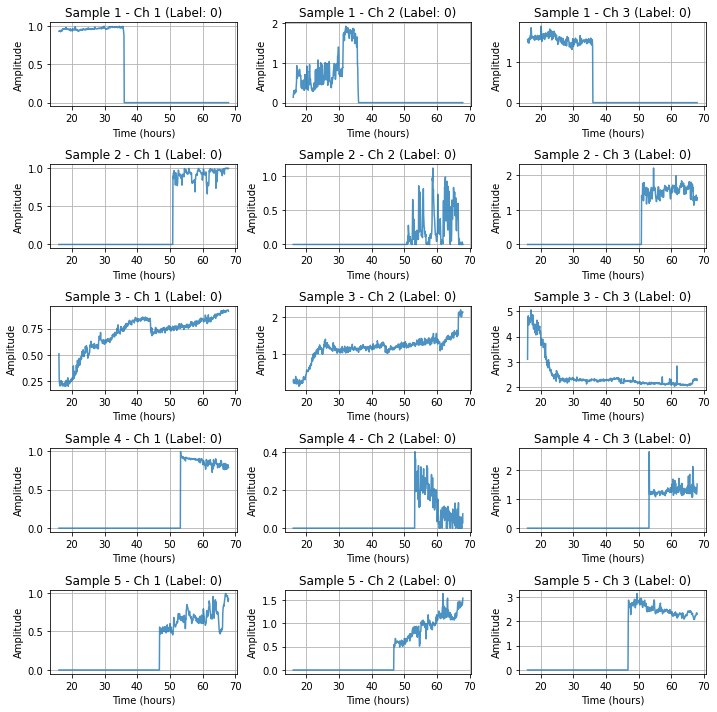

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter settings
latent_dim = 10  # Dimension of the latent space
initial_channels = 128  # Initial number of channels for CNN
start_time=16
seq_length = (68 - start_time) * 12  # Number of `5min` windows for 52 hours (624)
batch_size = 32
epochs = 100
alpha = 1e-6  # Weight for KL loss
patience = 10  # Define the number of epochs without improvement before stopping training
padding_method = 'constant'  # Use constant padding
is_augment = True  # Enable data augmentation
num_good_train=1
num_bad_train=1
num_good_test=1
num_bad_test=1
#column_names=['BCI', 'BSAR', 'SIQ', 'SIQ_alpha', 'SIQ_beta', 'SIQ_delta', 'SIQ_theta', 'SignalSD','Prob Seizure','spike hz']
#column_names=['meanskewamp']
#column_names=['Prob Seizure']
column_names=['BCI','spike hz','meanskewamp']
#column_names=['meanlogentropy']


num_eeg_channels=len(column_names)

is_VAEtrain_aug=False

# Define dataset folder paths
data_folder = '5min_smoothed_data/'  # Replace with the actual data folder path
valid_outcome_data = 'valid_patients_outcome.csv'
ssd_file = 'files_art_ssd_fts_predictions.csv'

# Create EEG dataset (labels are not used when training VAE)
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file=ssd_file,
    start_time=start_time,
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,
    use_labels=True,  # Use labels to determine class-based augmentation
    augment=False,  # Enable data augmentation
    num_good=1,
    num_bad=1,
    column_names=column_names
)

visualize_augmented_samples(eeg_dataset, num_samples=5)  # Random Visualize 5 sapmle

In [13]:
seed_value = 3  
torch.manual_seed(seed_value)
train_size = int(0.8 * len(eeg_dataset))
test_size = len(eeg_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])

print(f"Train set size (before augmentation): {len(train_dataset)}")
print(f"Train set label distribution: {count_labels(train_dataset)}")  
print(f"Test set size: {len(test_dataset)}")
print(f"Test set label distribution: {count_labels(test_dataset)}")  

# Augment the training set and the training set respectively
augmented_train_dataset = AugmentedEEGDataset(train_dataset, eeg_dataset, augment=is_augment, num_good=num_good_train, num_bad=num_bad_train)
augmented_test_dataset = AugmentedEEGDataset(test_dataset, eeg_dataset, augment=is_augment, num_good=num_good_test, num_bad=num_bad_test)

# Create DataLoader
if is_VAEtrain_aug:
    print("\n Augment the training set and the training set respectively:\n")
    aug_labels = [augmented_train_dataset[i][1] for i in range(len(augmented_train_dataset))]
    unique, counts = np.unique(aug_labels, return_counts=True)
    print(f"Train set size (after augmentation): {len(augmented_train_dataset)}")
    print(f"Train set label distribution (after augmentation): {dict(zip(unique, counts))}")



    aug_labels = [augmented_test_dataset[i][1] for i in range(len(augmented_test_dataset))]
    unique, counts = np.unique(aug_labels, return_counts=True)
    print(f"Test set size (after augmentation): {len(augmented_test_dataset)}")
    print(f"Test set label distribution (after augmentation): {dict(zip(unique, counts))}")

    train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(augmented_test_dataset, batch_size=batch_size, shuffle=False)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Train set size (before augmentation): 212
Train set label distribution: {0: 177, 1: 35}
Test set size: 54
Test set label distribution: {0: 46, 1: 8}


In [14]:
# Define model, loss function, and optimizer
vae_models = [VAE(latent_dim).to(device) for _ in range(num_eeg_channels)]  # ✅ **创建多个 VAE**

optimizer = optim.Adam(
    sum([list(model.parameters()) for model in vae_models], []),  # **合并所有 VAE 参数**
    lr=1e-3, weight_decay=1e-4
)

criterion = nn.MSELoss()

Epoch 1/100, Train Loss: 8.7850, Test Loss: 4.4534
Epoch 2/100, Train Loss: 1.8374, Test Loss: 1.4103
Epoch 3/100, Train Loss: 1.3453, Test Loss: 1.2158
Epoch 4/100, Train Loss: 1.0742, Test Loss: 0.8825
Epoch 5/100, Train Loss: 0.7285, Test Loss: 0.6814
Epoch 6/100, Train Loss: 0.5342, Test Loss: 0.5677
Epoch 7/100, Train Loss: 0.5008, Test Loss: 0.5228
Epoch 8/100, Train Loss: 0.4607, Test Loss: 0.4614
Epoch 9/100, Train Loss: 0.4076, Test Loss: 0.4345
Epoch 10/100, Train Loss: 0.3739, Test Loss: 0.4283
Epoch 11/100, Train Loss: 0.3503, Test Loss: 0.4305
Epoch 12/100, Train Loss: 0.3434, Test Loss: 0.3878
Epoch 13/100, Train Loss: 0.3153, Test Loss: 0.3726
Epoch 14/100, Train Loss: 0.3831, Test Loss: 0.3798
Epoch 15/100, Train Loss: 0.3364, Test Loss: 0.4771
Epoch 16/100, Train Loss: 0.3278, Test Loss: 0.3620
Epoch 17/100, Train Loss: 0.3040, Test Loss: 0.3545
Epoch 18/100, Train Loss: 0.2939, Test Loss: 0.3522
Epoch 19/100, Train Loss: 0.2559, Test Loss: 0.3217
Epoch 20/100, Train L

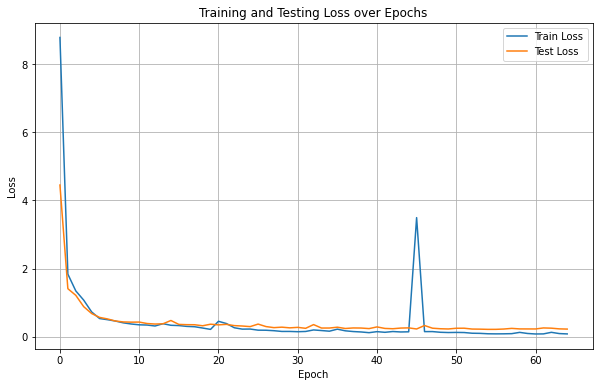

In [15]:
# Lists for training and testing losses (used for plotting)
train_losses = []
test_losses = []

# Early stopping variables
best_test_loss = float('inf')
epochs_no_improve = 0

# 🚀 **训练多个 VAE**
train_losses = []
test_losses = []

best_test_loss = float('inf')
epochs_no_improve = 0

for epoch in range(epochs):
    train_loss = train(vae_models, train_loader, optimizer, criterion, alpha, device, kl_loss_enabled=True)
    test_loss = test(vae_models, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # ✅ **早停机制**
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Validation loss has not improved for {patience} epochs. Early stopping...")
        break

# 🚀 **绘制损失曲线**
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

🔍 Detected 3 EEG channels.


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


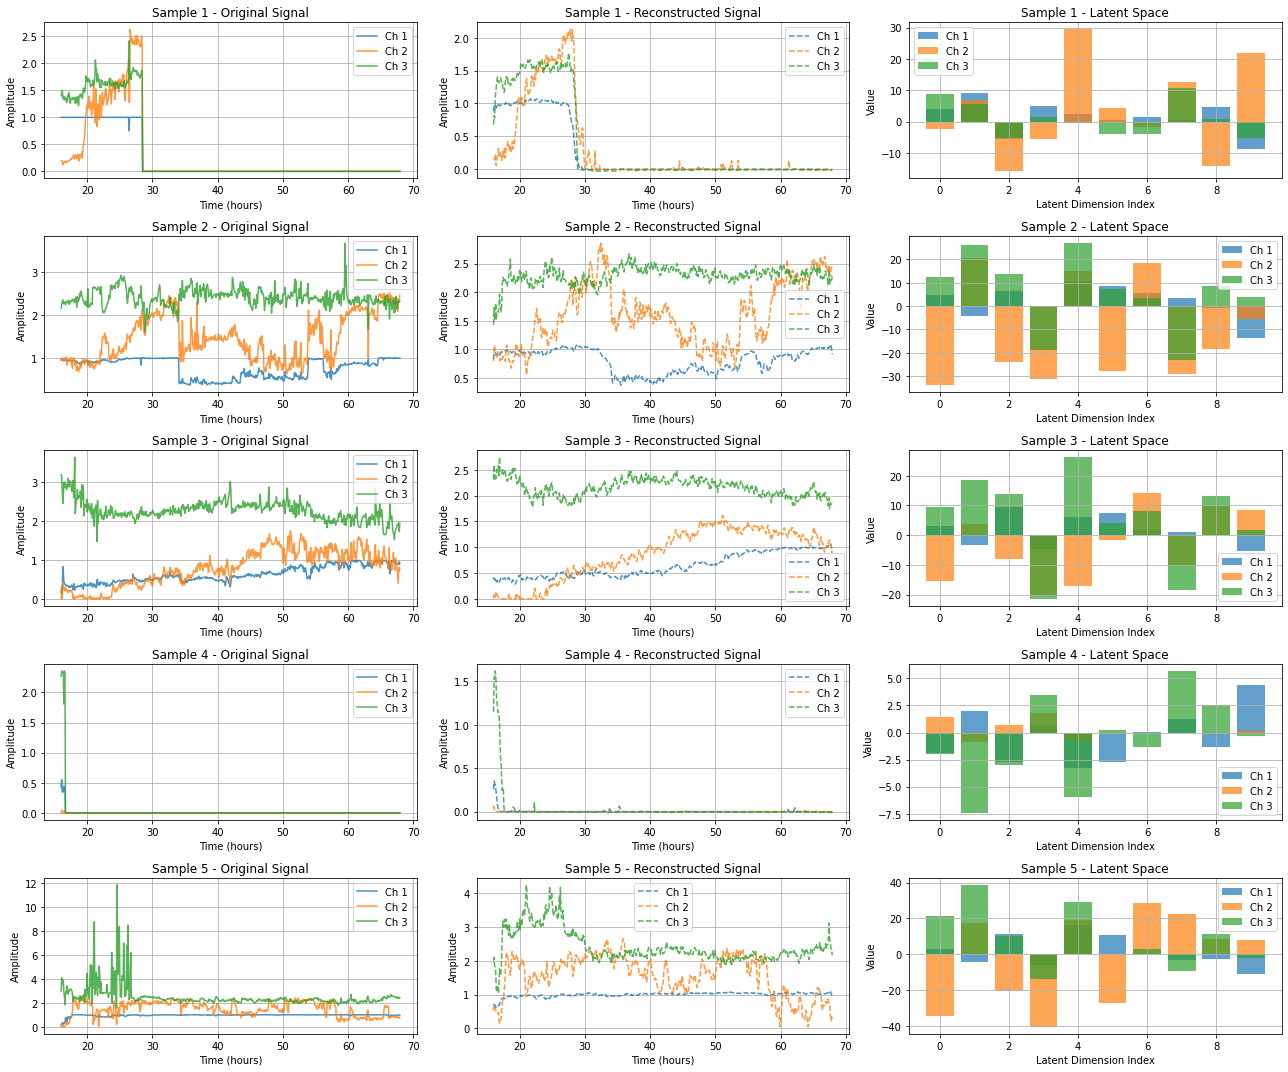

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

def visualize_reconstruction(vae_models, dataset, num_samples=5):
    """
    可视化多个 VAE 生成的 EEG 重建数据，以及 `latent space`
    
    参数:
    - vae_models: 3 个训练好的 VAE 模型
    - dataset: EEG 数据集实例
    - num_samples: 需要可视化的样本数
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for model in vae_models:
        model.eval()  # 设为评估模式

    num_channels = dataset[0][0].shape[0]  # 🚀 计算 EEG 通道数 (应该是 3)
    print(f"🔍 Detected {num_channels} EEG channels.")

    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 3 * num_samples))
    axes = np.atleast_2d(axes)  # 确保 axes 是二维，避免单样本时出错

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)  
        sample, _ = dataset[idx]  
        sample = sample.to(device)  # 🚀 (num_channels, 时间步)

        channel_reconstructions = []
        latent_vectors = []
        
        with torch.no_grad():
            for ch in range(num_channels):
                channel_data = sample[ch, :].unsqueeze(0).unsqueeze(0).to(device)  # 🚀 取单通道数据
                reconstruction, mu, _ = vae_models[ch](channel_data)

                channel_reconstructions.append(reconstruction.squeeze(0).cpu().numpy())  # 🚀 (624,)
                latent_vectors.append(mu.squeeze().cpu().numpy())  # 🚀 (latent_dim,)

        start_time = dataset.start_time  
        time_axis = np.linspace(start_time, start_time + (sample.shape[1] - 1) * 5 / 60, sample.shape[1])

        # **(1) 原始信号**
        for ch in range(num_channels):
            axes[i, 0].plot(time_axis, sample[ch].cpu().numpy(), label=f"Ch {ch+1}", alpha=0.8)
        axes[i, 0].set_title(f"Sample {i+1} - Original Signal")
        axes[i, 0].set_xlabel("Time (hours)")
        axes[i, 0].set_ylabel("Amplitude")
        axes[i, 0].legend()
        axes[i, 0].grid(True)

        # **(2) 重建信号**
        for ch in range(num_channels):
            axes[i, 1].plot(time_axis, channel_reconstructions[ch].squeeze(),  # ✅ 解决 ValueError
                            label=f"Ch {ch+1}", linestyle="dashed", alpha=0.8)
        axes[i, 1].set_title(f"Sample {i+1} - Reconstructed Signal")
        axes[i, 1].set_xlabel("Time (hours)")
        axes[i, 1].set_ylabel("Amplitude")
        axes[i, 1].legend()
        axes[i, 1].grid(True)

        # **(3) Latent Space**
        for ch in range(num_channels):
            axes[i, 2].bar(range(len(latent_vectors[ch])), latent_vectors[ch], alpha=0.7, label=f"Ch {ch+1}")
        axes[i, 2].set_title(f"Sample {i+1} - Latent Space")
        axes[i, 2].set_xlabel("Latent Dimension Index")
        axes[i, 2].set_ylabel("Value")
        axes[i, 2].legend()
        axes[i, 2].grid(True)

    plt.tight_layout()
    plt.savefig("vae_reconstruction_multichannel.png")  # 保存调试
    plt.show()

visualize_reconstruction(vae_models, eeg_dataset, num_samples=5)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
import numpy as np
import shap

# 🚀 提取训练集的 `latent feature`
X_train, y_train = extract_latent_features(vae_models, augmented_train_dataset)

# 🚀 提取测试集的 `latent feature`
X_test, y_test = extract_latent_features(vae_models, augmented_test_dataset)


# 🚀 确保 labels 是 numpy 数组
labels_train = np.array(y_train)
labels_test = np.array(y_test)

# 🚀 打印类别分布，检查数据是否平衡
print(f"Training set class distribution: {np.bincount(labels_train)}")
print(f"Testing set class distribution: {np.bincount(labels_test)}")

✅ Feature extraction complete! Extracted 212 samples.
✅ Feature extraction complete! Extracted 54 samples.
Training set class distribution: [177  35]
Testing set class distribution: [46  8]


✅ XGB Accuracy: 0.8148
✅ XGB AUC: 0.8071

✅ XGB Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90        46
           1       0.25      0.12      0.17         8

    accuracy                           0.81        54
   macro avg       0.55      0.53      0.53        54
weighted avg       0.77      0.81      0.79        54


✅ XGB Confusion Matrix:
[[43  3]
 [ 7  1]]
Expected feature count: 30, Generated feature count: 30


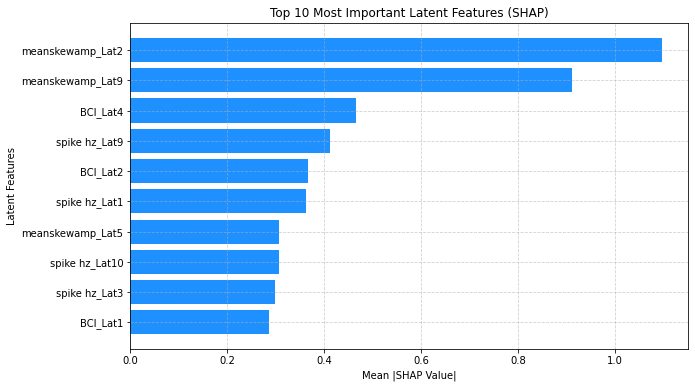

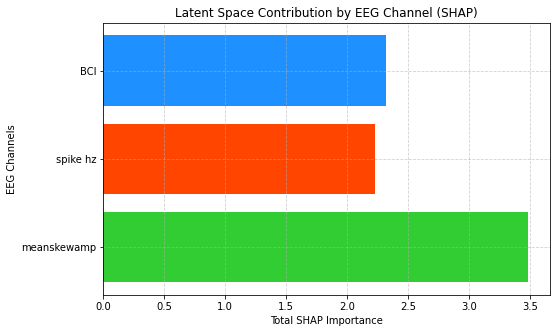

In [18]:
## 🚀 **创建 XGBoost 分类模型**
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# 🚀 **进行预测**
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

# 🚀 **计算 AUC 和准确率**
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb[:, 1])  # Use probability of the positive class
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"✅ XGB Accuracy: {accuracy_xgb:.4f}")
print(f"✅ XGB AUC: {auc_xgb:.4f}")
print("\n✅ XGB Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("\n✅ XGB Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# 🚀 使用 SHAP 解释模型
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# 🚀 画出所有 `latent feature` 的贡献
# 🚀 创建 `SHAP` 解释器
explainer = shap.TreeExplainer(xgb_model)

# 🚀 计算 `SHAP` 值
shap_values = explainer.shap_values(X_test)
# 🚀 计算特征重要性（取 SHAP 值的平均绝对值）
feature_importance = np.abs(shap_values).mean(axis=0)

# 🚀 生成特征名称
num_channels = num_eeg_channels  # 🚀 这里严格遵守变量命名
feature_names = [f"{column_names[ch]}_Lat{i+1}" for ch in range(num_channels) for i in range(latent_dim)]

# 🚀 确保 feature_names 维度正确
num_features = X_test.shape[1]
feature_names = feature_names[:num_features]

print(f"Expected feature count: {num_features}, Generated feature count: {len(feature_names)}")

# 🚀 可视化 - 方案 1：Top 10 最重要的 `latent feature`
sorted_idx = np.argsort(feature_importance)[::-1]  # 按照重要性排序
top_k = 10  # 取最重要的前 10 个特征

plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in sorted_idx[:top_k]], feature_importance[sorted_idx[:top_k]], color='dodgerblue')
plt.xlabel("Mean |SHAP Value|")
plt.ylabel("Latent Features")
plt.title("Top 10 Most Important Latent Features (SHAP)")
plt.gca().invert_yaxis()  # 反转 y 轴，使最重要的特征在顶部
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# 🚀 可视化 - 方案 2：按通道计算特征贡献
channel_importance = [
    np.sum(feature_importance[ch * latent_dim : (ch + 1) * latent_dim]) for ch in range(num_channels)
]

plt.figure(figsize=(8, 5))
plt.barh([f"{column_names[ch]}" for ch in range(num_channels)], channel_importance, color=['dodgerblue', 'orangered', 'limegreen'])
plt.xlabel("Total SHAP Importance")
plt.ylabel("EEG Channels")
plt.title("Latent Space Contribution by EEG Channel (SHAP)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [19]:
# Create and train the SVM model
svm_model = SVC(kernel='linear', C=1.0, class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.decision_function(X_test)  # SVM requires decision_function

# Compute AUC
auc_svm = roc_auc_score(y_test, y_pred_proba_svm)  # Use decision function scores
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"\nSVM Accuracy: {accuracy_svm:.4f}")
print(f"SVM AUC: {auc_svm:.4f}")
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


SVM Accuracy: 0.7037
SVM AUC: 0.7935

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79        46
           1       0.32      0.88      0.47         8

    accuracy                           0.70        54
   macro avg       0.64      0.77      0.63        54
weighted avg       0.87      0.70      0.75        54


SVM Confusion Matrix:
[[31 15]
 [ 1  7]]


In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

# 🚀 1️⃣ 可视化 `latent feature` 作为 Heatmap
def visualize_latent_heatmap(latent_features, labels):
    """
    用 Heatmap 可视化 `latent feature`，适用于直接查看特征分布。

    参数：
    - latent_features: 2D numpy array, 形状为 (样本数, 特征维度)
    - labels: 1D numpy array, 样本标签
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(latent_features, cmap='coolwarm', center=0, xticklabels=False, yticklabels=False)
    plt.title("Latent Feature Heatmap")
    plt.xlabel("Latent Dimensions")
    plt.ylabel("Samples")
    plt.colorbar(label="Feature Value")
    plt.show()

# 🚀 2️⃣ PCA 降维 + 2D/3D 可视化
def visualize_pca(latent_features, labels, dimensions=2):
    """
    用 PCA 降维 `latent feature` 并进行可视化。

    参数：
    - latent_features: 2D numpy array, 形状为 (样本数, 特征维度)
    - labels: 1D numpy array, 样本标签
    - dimensions: int, 降维目标维度 (2 或 3)
    """
    pca = PCA(n_components=dimensions)
    reduced_features = pca.fit_transform(latent_features)

    color_map = {0: 'blue', 1: 'red'}
    colors = [color_map[label] for label in labels]

    if dimensions == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)

        handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        plt.legend(handles=handles, title="Labels")

        plt.title("PCA Projection of Latent Space (2D)")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.grid(True)
        plt.show()

    elif dimensions == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=colors, alpha=0.7)

        handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        ax.legend(handles=handles, title="Labels")
        ax.set_title("PCA Projection of Latent Space (3D)")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        plt.show()

# 🚀 3️⃣ t-SNE 代替 `UMAP`
def visualize_tsne(latent_features, labels, dimensions=2):
    """
    用 t-SNE 降维 `latent feature` 并进行可视化。

    参数：
    - latent_features: 2D numpy array, 形状为 (样本数, 特征维度)
    - labels: 1D numpy array, 样本标签
    - dimensions: int, 降维目标维度 (2)
    """
    tsne = TSNE(n_components=dimensions, perplexity=30, random_state=42)
    reduced_features = tsne.fit_transform(latent_features)

    color_map = {0: 'blue', 1: 'red'}
    colors = [color_map[label] for label in labels]

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)

    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
               Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
    plt.legend(handles=handles, title="Labels")

    plt.title("t-SNE Projection of Latent Space (2D)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()

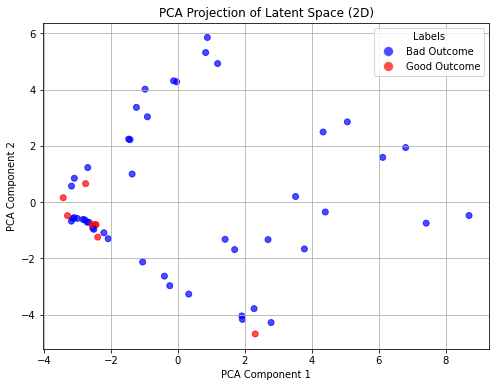

/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


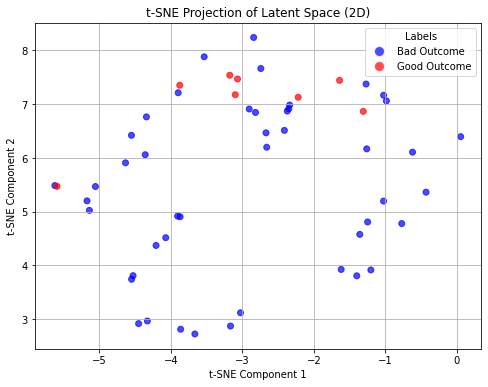

In [21]:
# 🚀 运行可视化（确保不会让 Mac 死机）
#visualize_latent_heatmap(X_test, y_test)  # 直接看 `latent feature` 分布
visualize_pca(X_test, y_test, dimensions=2)  # `PCA` 降到 `2D` 可视化
visualize_tsne(X_test, y_test, dimensions=2)  # `t-SNE` 替代 `UMAP` 可视化

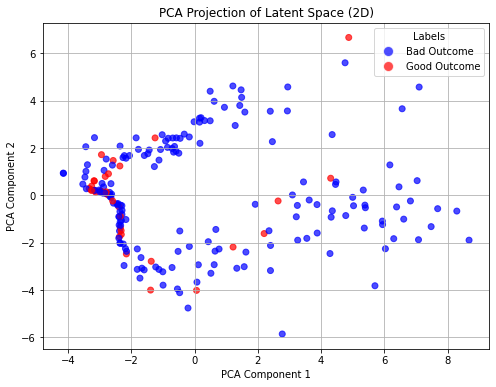

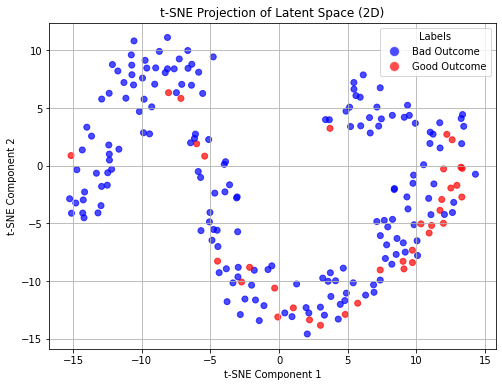

In [22]:
visualize_pca(X_train, y_train, dimensions=2)  # `PCA` 降到 `2D` 可视化
visualize_tsne(X_train, y_train, dimensions=2)

✅ Feature extraction complete! Extracted 266 samples.


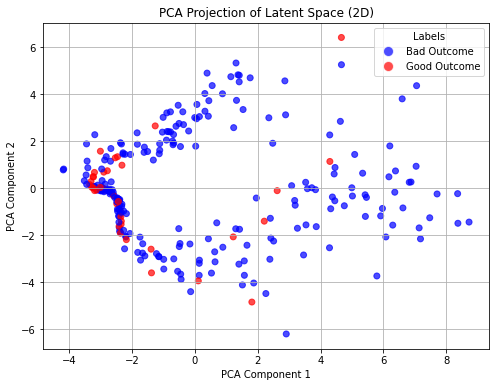

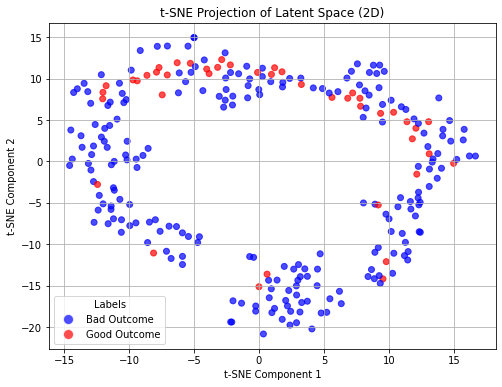

In [23]:
X_ALL, y_ALL= extract_latent_features(vae_models, eeg_dataset)
visualize_pca(X_ALL, y_ALL, dimensions=2)  # `PCA` 降到 `2D` 可视化
visualize_tsne(X_ALL, y_ALL, dimensions=2) 

In [24]:
# 🚀 **进行预测**
y_pred_xgb = xgb_model.predict(X_ALL)
y_pred_proba_xgb = xgb_model.predict_proba(X_ALL)

# 🚀 **计算 AUC 和准确率**
auc_xgb = roc_auc_score(y_ALL, y_pred_proba_xgb[:, 1])  # Use probability of the positive class
accuracy_xgb = accuracy_score(y_ALL, y_pred_xgb)

print(f"✅ XGB Accuracy: {accuracy_xgb:.4f}")
print(f"✅ XGB AUC: {auc_xgb:.4f}")
print("\n✅ XGB Classification Report:")
print(classification_report(y_ALL, y_pred_xgb))
print("\n✅ XGB Confusion Matrix:")
print(confusion_matrix(y_ALL, y_pred_xgb))

✅ XGB Accuracy: 0.9211
✅ XGB AUC: 0.9546

✅ XGB Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       223
           1       0.82      0.65      0.73        43

    accuracy                           0.92       266
   macro avg       0.88      0.81      0.84       266
weighted avg       0.92      0.92      0.92       266


✅ XGB Confusion Matrix:
[[217   6]
 [ 15  28]]


In [25]:
latent_features,labels= extract_latent_features(vae_models, eeg_dataset)

✅ Feature extraction complete! Extracted 266 samples.


✅ Global Good Outcome Count: 43
✅ Global Bad Outcome Count: 223
✅ Global Good/Bad Ratio: 0.1928
✅ Best num_clusters (using Silhouette Score): 2

📊 Clustering Good/Bad Ratios:
✅ Cluster 1: Good Count = 6, Bad Count = 80, Good/Bad Ratio = 0.0750
✅ Cluster 2: Good Count = 37, Bad Count = 143, Good/Bad Ratio = 0.2587


/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


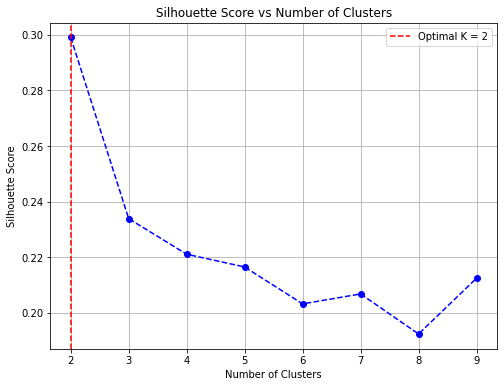

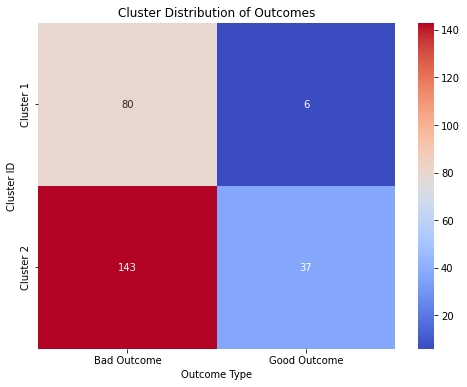

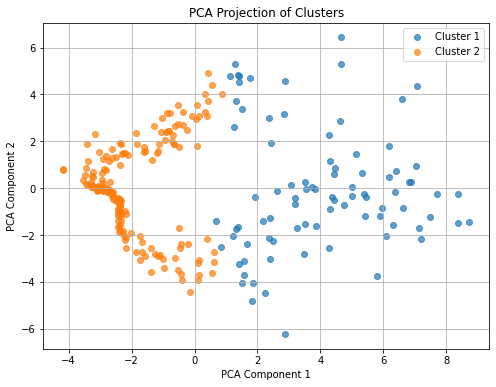


📊 Statistical Test Results:
Chi-Square Statistic: 6.9475
Chi-Square P-Value: 0.0084
Degrees of Freedom: 1
Expected Frequencies Table:
[[ 72.09774436  13.90225564]
 [150.90225564  29.09774436]]
✅ Chi-Square Test: The clustering significantly affects the Good/Bad distribution.

📊 T-Test Results:
T-Statistic: -0.2825
T-Test P-Value: 0.8041
❌ T-Test: No significant difference in Good/Bad Ratio among clusters.


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.decomposition import PCA

# 🚀 1️⃣ 计算全局 Good/Bad Ratio
total_good = np.sum(labels == 1)
total_bad = np.sum(labels == 0)
global_good_bad_ratio = total_good / total_bad if total_bad > 0 else np.inf

print(f"✅ Global Good Outcome Count: {total_good}")
print(f"✅ Global Bad Outcome Count: {total_bad}")
print(f"✅ Global Good/Bad Ratio: {global_good_bad_ratio:.4f}")

# 🚀 2️⃣ 选择最佳 num_clusters (使用 Silhouette Score)
silhouette_scores = []
possible_clusters = range(2, 10)  # 你可以调整最大聚类数

for k in possible_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(latent_features)
    score = silhouette_score(latent_features, cluster_labels)
    silhouette_scores.append(score)

# 🚀 3️⃣ 找到最佳 `num_clusters`
optimal_clusters = possible_clusters[np.argmax(silhouette_scores)]
print(f"✅ Best num_clusters (using Silhouette Score): {optimal_clusters}")

# 🚀 4️⃣ 重新训练最佳 K-Means 模型
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(latent_features)

# 🚀 5️⃣ 统计不同类的 Good / Bad Outcome 和计算每个群组的 Good/Bad Ratio
contingency_table = np.zeros((optimal_clusters, 2))  # (Bad Outcome, Good Outcome)
group_good_bad_ratios = []

print("\n📊 Clustering Good/Bad Ratios:")
for i in range(optimal_clusters):
    n_bad = np.sum((cluster_labels == i) & (labels == 0))  # Bad Outcome 数量
    n_good = np.sum((cluster_labels == i) & (labels == 1))  # Good Outcome 数量
    contingency_table[i, 0] = n_bad
    contingency_table[i, 1] = n_good
    ratio = n_good / (n_bad + 1e-6)  # 避免除零错误
    group_good_bad_ratios.append(ratio)
    print(f"✅ Cluster {i+1}: Good Count = {n_good}, Bad Count = {n_bad}, Good/Bad Ratio = {ratio:.4f}")

# 🚀 6️⃣ 进行卡方检验 (Chi-Square Test)
chi2, p, dof, expected = chi2_contingency(contingency_table)

# 🚀 7️⃣ 进行 T 检验 (判断群组的 Good/Bad Ratio 是否显著不同)
t_stat, t_p_value = ttest_ind(group_good_bad_ratios, np.full_like(group_good_bad_ratios, global_good_bad_ratio))

# 🚀 8️⃣ 画出 Silhouette Score 曲线
plt.figure(figsize=(8, 6))
plt.plot(possible_clusters, silhouette_scores, marker='o', linestyle='--', color='b')
plt.axvline(optimal_clusters, linestyle="--", color="r", label=f"Optimal K = {optimal_clusters}")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.legend()
plt.grid(True)
plt.show()

# 🚀 9️⃣ 可视化不同类的 Outcome 分布 (热力图)
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap="coolwarm", fmt=".0f", xticklabels=["Bad Outcome", "Good Outcome"], yticklabels=[f"Cluster {i+1}" for i in range(optimal_clusters)])
plt.xlabel("Outcome Type")
plt.ylabel("Cluster ID")
plt.title("Cluster Distribution of Outcomes")
plt.show()

# 🚀 🔟 PCA 降维到 2D 进行可视化 (看看聚类效果)
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_features)

plt.figure(figsize=(8, 6))
for i in range(optimal_clusters):
    cluster_mask = cluster_labels == i
    plt.scatter(latent_pca[cluster_mask, 0], latent_pca[cluster_mask, 1], label=f"Cluster {i+1}", alpha=0.7)

plt.legend()
plt.title("PCA Projection of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

# 🚀 🔟 输出统计检验结果
print("\n📊 Statistical Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"Chi-Square P-Value: {p:.4f}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies Table:")
print(expected)
if p < 0.05:
    print("✅ Chi-Square Test: The clustering significantly affects the Good/Bad distribution.")
else:
    print("❌ Chi-Square Test: No significant effect of clustering on Good/Bad distribution.")

print("\n📊 T-Test Results:")
print(f"T-Statistic: {t_stat:.4f}")
print(f"T-Test P-Value: {t_p_value:.4f}")

if t_p_value < 0.05:
    print("✅ T-Test: The Good/Bad Ratio varies significantly across clusters.")
else:
    print("❌ T-Test: No significant difference in Good/Bad Ratio among clusters.")


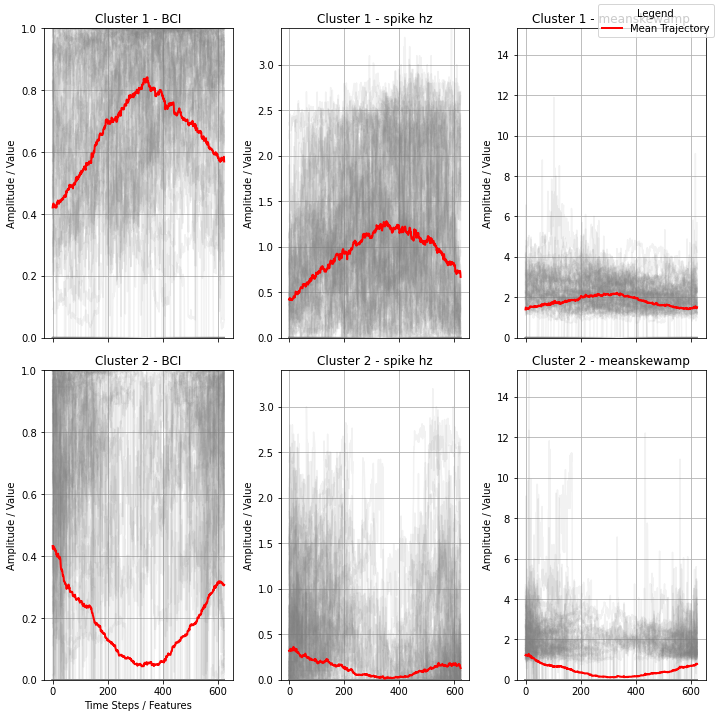

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 🚀 获取原始 EEG 数据
raw_data = np.array([eeg_dataset[i][0].numpy() for i in range(len(eeg_dataset))])  # (样本数, 通道数, 时间步)

# 🚀 画出不同 Cluster 的所有曲线（淡色背景）+ 平均值（突出显示）
fig, axes = plt.subplots(optimal_clusters, num_channels, figsize=(10, 5 * optimal_clusters), sharex=True)

if num_channels == 1:
    axes = np.expand_dims(axes, axis=1)  # 确保单通道情况下 axes 可迭代

for i in range(optimal_clusters):  # 遍历不同 Cluster
    cluster_mask = cluster_labels == i

    for ch in range(num_channels):  # 遍历不同 EEG 通道
        # 画出该 Cluster 内所有曲线（淡色背景）
        for sample in raw_data[cluster_mask, ch, :]:
            axes[i, ch].plot(sample, color="gray", alpha=0.1)  # 设置灰色背景，透明度低

        # 画出该 Cluster 内的均值曲线（高亮）
        cluster_data_mean = np.mean(raw_data[cluster_mask, ch, :], axis=0)
        axes[i, ch].plot(cluster_data_mean, color="red", linewidth=2, label=f"Cluster {i+1} Mean")

        # 设置标题
        axes[i, ch].set_title(f"Cluster {i+1} - {column_names[ch]}")
        axes[i, ch].set_ylabel("Amplitude / Value")
        axes[i, ch].grid(True)
        
        # 设置每个子图的 y 轴范围为最合适的范围
        min_val = np.min(raw_data[:, ch, :])
        max_val = np.max(raw_data[:, ch, :])
        axes[i, ch].set_ylim(min_val, max_val)

# 统一 X 轴标签
axes[-1, 0].set_xlabel("Time Steps / Features")

# 添加图例
handles = [plt.Line2D([0], [0], color="red", linewidth=2, label="Mean Trajectory")]
fig.legend(handles=handles, loc="upper right", title="Legend")

plt.tight_layout()
plt.show()


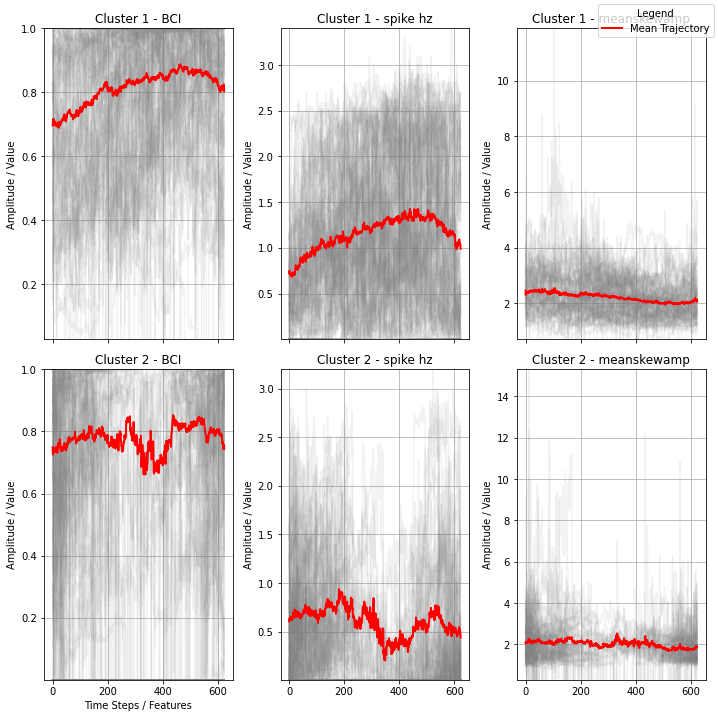

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 🚀 获取原始 EEG 数据
raw_data = np.array([eeg_dataset[i][0].numpy() for i in range(len(eeg_dataset))])  # (样本数, 通道数, 时间步)

# 🚀 画出不同 Cluster 的所有曲线（淡色背景）+ 平均值（突出显示）
fig, axes = plt.subplots(optimal_clusters, num_channels, figsize=(10, 5 * optimal_clusters), sharex=True)

if num_channels == 1:
    axes = np.expand_dims(axes, axis=1)  # 确保单通道情况下 axes 可迭代

for i in range(optimal_clusters):  # 遍历不同 Cluster
    cluster_mask = cluster_labels == i

    for ch in range(num_channels):  # 遍历不同 EEG 通道
        # 画出该 Cluster 内所有曲线（淡色背景）
        for sample in raw_data[cluster_mask, ch, :]:
            axes[i, ch].plot(sample, color="gray", alpha=0.1)  # 设置灰色背景，透明度低

        # 计算均值，忽略 0 值
        cluster_data = raw_data[cluster_mask, ch, :]
        cluster_data_no_zeros = np.where(cluster_data == 0, np.nan, cluster_data)  # 把 0 替换成 NaN
        cluster_data_mean = np.nanmean(cluster_data_no_zeros, axis=0)  # 计算均值，忽略 NaN

        # 画出该 Cluster 内的均值曲线（高亮）
        axes[i, ch].plot(cluster_data_mean, color="red", linewidth=2, label=f"Cluster {i+1} Mean")

        # 设置标题
        axes[i, ch].set_title(f"Cluster {i+1} - {column_names[ch]}")
        axes[i, ch].set_ylabel("Amplitude / Value")
        axes[i, ch].grid(True)
        
        # 设置每个子图的 y 轴范围为最合适的范围
        min_val = np.nanmin(cluster_data_no_zeros)
        max_val = np.nanmax(cluster_data_no_zeros)
        axes[i, ch].set_ylim(min_val, max_val)

# 统一 X 轴标签
axes[-1, 0].set_xlabel("Time Steps / Features")

# 添加图例
handles = [plt.Line2D([0], [0], color="red", linewidth=2, label="Mean Trajectory")]
fig.legend(handles=handles, loc="upper right", title="Legend")

plt.tight_layout()
plt.show()

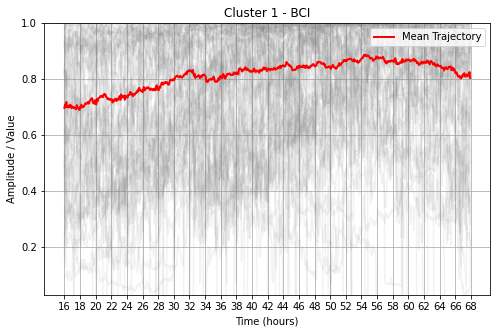

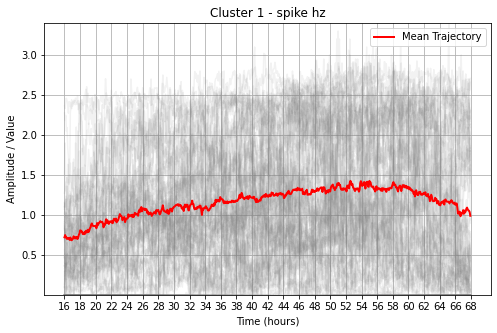

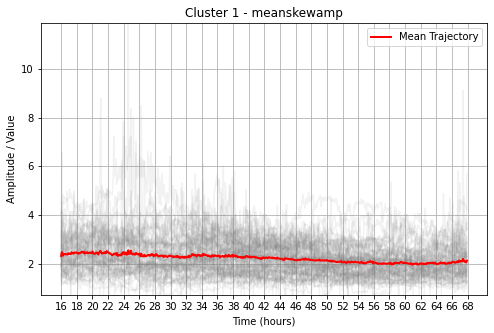

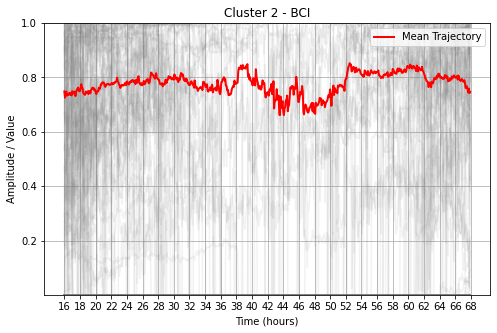

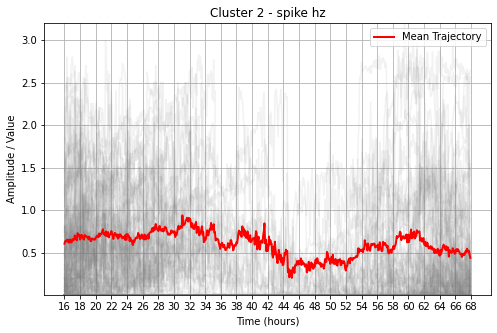

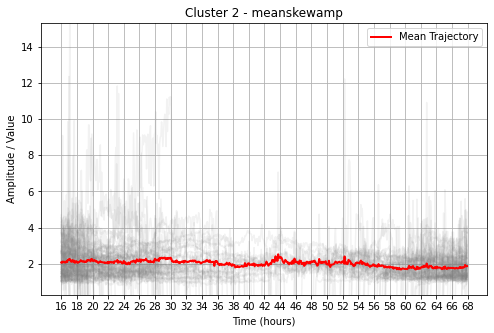

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# 🚀 获取原始 EEG 数据
raw_data = np.array([eeg_dataset[i][0].numpy() for i in range(len(eeg_dataset))])  # (样本数, 通道数, 时间步)

# **时间轴处理**
start_time = 16  # 小时，数据采集开始时间
time_per_step = 5 / 60  # 每个时间步为 5 分钟，换算成小时
time_axis = np.arange(raw_data.shape[2]) * time_per_step + start_time  # 计算时间轴

# 🚀 遍历不同 Cluster 和 通道，分别画出单独的图
for i in range(optimal_clusters):  # 遍历不同 Cluster
    cluster_mask = cluster_labels == i

    for ch in range(num_channels):  # 遍历不同 EEG 通道
        plt.figure(figsize=(8, 5))  # 生成单独的 Figure，每次一个

        # 画出该 Cluster 内所有曲线（淡色背景）
        for sample in raw_data[cluster_mask, ch, :]:
            plt.plot(time_axis, sample, color="gray", alpha=0.1, label="Raw Data" if sample is raw_data[cluster_mask, ch, :][0] else "")

        # 计算均值，忽略 0 值
        cluster_data = raw_data[cluster_mask, ch, :]
        cluster_data_no_zeros = np.where(cluster_data == 0, np.nan, cluster_data)  # 把 0 替换成 NaN
        cluster_data_mean = np.nanmean(cluster_data_no_zeros, axis=0)  # 计算均值，忽略 NaN

        # 画出该 Cluster 内的均值曲线（高亮）
        plt.plot(time_axis, cluster_data_mean, color="red", linewidth=2, label="Mean Trajectory")

        # 设置标题、标签、网格
        plt.title(f"Cluster {i+1} - {column_names[ch]}")
        plt.ylabel("Amplitude / Value")
        plt.xlabel("Time (hours)")
        plt.grid(True)

        # 设置 y 轴范围
        min_val = np.nanmin(cluster_data_no_zeros)
        max_val = np.nanmax(cluster_data_no_zeros)
        plt.ylim(min_val, max_val)

        # 调整 X 轴刻度，确保标签可读
        plt.xticks(np.arange(start_time, time_axis[-1] + 1, step=2))  # 每 2 小时标一个点

        # 添加图例
        plt.legend(loc="upper right")

        # 显示图
        plt.show()